In [2]:
# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random
import glob

import csv
from scipy import ndimage, misc
from tqdm import tqdm

In [129]:
# [STAR] Attribute and Category Model

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class MyAttrCateModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model    = models.resnet18(pretrained=True)
        self.model.fc = Identity()
        
        #self.attr_layer = nn.Sequential(nn.Linear(512, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 26, bias=False)
        #                               )
        
        #self.cate_layer = nn.Sequential(nn.Linear(512, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 50, bias=False))
        self.attr_layer = nn.Linear(512, 26)
        self.cate_layer = nn.Linear(512, 50)
    
    def forward(self, x):
        out1     = self.model(x)
        attr_out = self.attr_layer(out1)
        cate_out = self.cate_layer(out1)
        #cate_out = torch.flatten(cate_out)
        return attr_out, cate_out

class MyAttrCateModel50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model    = models.resnet50(pretrained=True)
        self.model.fc = Identity()
        
        #self.attr_layer = nn.Sequential(nn.Linear(2048, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 26, bias=False))
        #self.cate_layer = nn.Sequential(nn.Linear(2048, 128, bias=False), 
        #                                nn.ReLU(inplace=True),
        #                                nn.Linear(128, 50, bias=False))
        self.attr_layer = nn.Linear(2048, 201)
        self.cate_layer = nn.Linear(2048, 6)
    
    def forward(self, x):
        out1     = self.model(x)
        attr_out = self.attr_layer(out1)
        cate_out = self.cate_layer(out1)
        #cate_out = torch.flatten(cate_out)
        return attr_out, cate_out
#model  = MyAttrCateModel()
# x      = torch.randn(1, 3, 224, 224)
# output = model(x)
# print(output[0].shape, output[1].shape)

#print(model)
#model_ft = model_ft.to(device)

In [21]:
# TEMP Code to Read the BP images

images = glob.glob('/home/yu-hao/Downloads/30 Styles-20210216T225758Z-001/30 Styles/**/*.png', recursive=True)
#print(images)
filtered_images  = []
counter          = 0

for m in images:
    #if 'Top' in m or 'Bottom' in m :
        #continue
    filtered_images.append(m[64:])
valid_dataset = "\n".join(filtered_images)

f = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/newval.txt", "w")
f.write(valid_dataset)
f.close()

#print(filtered_images)

In [96]:
# [STAR] Data Loaders for Fashion Dataset

from __future__ import division
import os

import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data.dataset import Dataset


class AttrDataset(Dataset):
    CLASSES = None
    
    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 cate_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 idx2id=None):
        self.img_path = img_path

        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r')
        self.img_list = [x.strip() for x in fp]

        # read attribute labels and category annotations
        self.labels = np.loadtxt(label_file, dtype=np.float32)

        # read categories
        self.categories = []
        catefn = open(cate_file).readlines()
        for i, line in enumerate(catefn):
            self.categories.append(line.strip('\n'))

        self.img_size = img_size
    
    def get_basic_item(self, idx):
        print(os.path.join(self.img_path, self.img_list[idx]))
        img = Image.open(os.path.join(self.img_path,
                                      self.img_list[idx])).convert('RGB')

        width, height  = img.size
        print('Original Image size is ', width, height)
        # Very Important
        # For getting the cropped and resized region of interest image
        img.thumbnail(self.img_size, Image.ANTIALIAS)
        img   = self.transform(img)

        label    = torch.from_numpy(self.labels[idx])
        cate     = torch.LongTensor([int(self.categories[idx]) - 1])

        data = {'img': img, 'attr': label, 'cate': cate}
        return data

    def __getitem__(self, idx):
        return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)


class ValidAttrDataset(Dataset):
    CLASSES = None
    
    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 cate_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 idx2id=None):
        self.img_path = img_path

        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r').read().split('\n')
        self.img_list = fp#[x.strip() for x in fp]
        
        self.img_size = img_size
    
    def get_basic_item(self, idx):
        try:
            #print(os.path.join(self.img_path, self.img_list[idx]))
            img = Image.open(os.path.join(self.img_path,
                                          self.img_list[idx])).convert('RGB')

            width, height  = img.size
            img.resize((width//2, height//2))
            width, height  = img.size

            #print('Original Image size is ', width, height)
            # Very Important
            # For getting the cropped and resized region of interest image
            img.thumbnail(self.img_size, Image.ANTIALIAS)
            img   = self.transform(img)

            #label    = torch.from_numpy(self.labels[idx])
            #cate     = torch.LongTensor([int(self.categories[idx]) - 1])

            data = {'img': img, 'imgpath': os.path.join(self.img_path,
                                          self.img_list[idx])}#, 'attr': label, 'cate': cate}
            return data
        except:
            pass

    def __getitem__(self, idx):
        return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)

img_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/"
img_file   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"
label_file = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_attr.txt"
cate_file  = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_cate.txt"
img_size   = [224, 224]
#img_size   = [256, 256]

landmark_file = None
bbox_file     = None

d1 = AttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

img_file   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/val.txt"
label_file = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/val_attr.txt"
cate_file  = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/val_cate.txt"

d2 = AttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

img_path   = "/home/yu-hao/Downloads/30 Styles-20210216T225758Z-001/30 Styles/"
img_file   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/newval.txt"

d3 = ValidAttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

from torch.utils.data import DataLoader


def build_dataloader(dataset, batch_size, shuffle):
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=False)
    return data_loader

train_data_loader = build_dataloader(d1, 4, True)
val_data_loader   = build_dataloader(d2, 4, False)

model  = MyAttrCateModel50()
#model  = MyAttrCateModel()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
lr_scheduler = None


In [222]:
# [STAR] Data Loaders for New Fashion Dataset

from __future__ import division
import os

import numpy as np
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data.dataset import Dataset

from os import path

class AttrDataset(Dataset):
    CLASSES = None
    
    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 cate_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 idx2id=None):
        self.img_path = img_path

        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r').read().split('\n')
        
        self.img_list   = []
        self.labels     = []
        self.categories = []
        
        self.all_categories = ['accessories', 'bottoms' ,'dresses', 'footwear' ,'outerwear', 'tops']
        self.all_labels     = ['totebag', 'beige', 'black', 'brown', 'darkred', 'green', 'grey', 'lightpink', 'multicolor', 'offwhite', 'orange', 'pink', 'purple', 'yellow', 'clutchbag', 'silver', 'white', 'neckscarf', 'golden', 'lightblue', 'lightgreen', 'navyblue', 'red', 'redfloral', 'layerednecklace', 'cream', 'ecru', 'hoops', 'rosegold', 'crossbody', 'blue', 'mustard', 'skinnybelt', 'navy', 'tan', 'statementbelt', 'burgundy', 'camel', 'darkbrown', 'chainnecklace', 'statementnecklace', 'teardropearrings', 'strawtote', 'camelbrown', 'scrunchie', 'blackwhite', 'headband', 'olive', 'crushbag', 'beltbag', 'blackvirgin', 'bucketbag', 'backpack', 'khakigreen', 'leopard', 'rosepink', 'minibag', 'socks', 'beanie', 'buckethat', 'fedora', 'ivory', 'olivegreen', 'jeans', 'long', 'lightdenim', 'mediumdenim', 'darkdenim', 'regular', 'lightblack', 'ankle', 'frayed', 'boyfriend', 'bootcut', 'distressed', 'skinny', 'straight', 'wide', 'highrise', 'midrise', 'lowrise', 'pant', 'blackcheck', 'maroon', 'greycheck', 'darkgrey', 'browncheck', 'greyblue', 'legging', 'plum', 'skyblue', 'loose', 'metallicblack', 'bluefloral', 'trouser', 'darkgreen', 'wideleg', 'pinkfloral', 'darkdenimblue', 'skirts', 'aline', 'high', 'denimblue', 'oatmeal', 'asymmetrical', 'brownfloral', 'mettalicpink', 'blackfloral', 'greyfloral', 'pleated', 'blush', 'slit', 'tulle', 'wrap', 'creamfloral', 'maxi', 'greenfloral', 'yellowfloral', 'mini', 'taupe', 'khaki', 'knee', 'midi', 'tank', 'sleeveless', 'dustypink', 'short', 'shortsleeves', 'puff', 'longsleeves', 'whitefloral', 'lightpurple', 'tflength', 'oneshoulder', 'strapless', 'turtleneck', 'lightgrey', 'fitandflare', 'openback', 'lightskyblue', 'ruched', 'slip', 'sweater', 'tea', 'midcalfboots', 'kneehighboots', 'pumps', 'combatboots', 'chelseaboots', 'flats', 'wedges', 'mules', 'darkblue', 'platformsandals', 'blockheelsandals', 'classicsneakers', 'retrorunning', 'lowtopsneakers', 'hightopsneakers', 'crocs', 'slides', 'turquoice', 'slippers', 'platformsneakers', 'slingbacksandals', 'loafers', 'booties', 'blazer', 'collarless', 'doublebreasted', 'onebutton', 'oversized', 'anthracitegrey', 'singlebreasted', 'midnightblue', 'coat', 'peacoat', 'button', 'quilted', 'nobutton', 'robe', 'trench', 'teddy', 'jacket', 'denim', 'moto', 'puffer', 'withoutsleeves', 'shearling', 'crewneck', 'tight', 'collared', 'cardigan', 'vneck', 'crop', 'square', 'tshirt', 'mock', 'blouse', 'smocked', 'lonsleeves']
        
        for t in fp:
            self.img_list.append(t.split(',')[0])
            self.categories.append(self.all_categories.index(t.split(',')[1]))
            temp = np.zeros(len(self.all_labels))
            
            for k in t.split(',')[2:]:
                if k in self.all_labels:
                    temp[self.all_labels.index(k)] = 1
                    #temp.append(self.all_labels.index(k))
            self.labels.append(temp)
        
        #self.img_list = [x.strip() for x in fp]

        # read attribute labels and category annotations
        #self.labels = np.loadtxt(label_file, dtype=np.float32)

        # read categories
        #self.categories = []
        #catefn = open(cate_file).readlines()
        #for i, line in enumerate(catefn):
        #    self.categories.append(line.strip('\n'))

        self.img_size = img_size
    
    def get_basic_item(self, idx):
        #print(self.img_list[idx])
        if path.exists(self.img_list[idx].replace('.jpg', '.JPG')):
            img = Image.open(self.img_list[idx].replace('.jpg', '.JPG')).convert('RGB')
            width, height  = img.size
            new_width  = width//4
            new_height = height//4
            
            img = img.resize((new_width, new_height), Image.ANTIALIAS)
            
            #elif path.exists(self.img_list[idx].replace('.jpg', ''))
            
            #print('Original Image size is ', width, height)
            # Very Important
            # For getting the cropped and resized region of interest image
            img.thumbnail(self.img_size, Image.ANTIALIAS)
            #print('Downsampled Image size is ', width, height)
            img   = self.transform(img)
            
            #print('Original Image size is ', width, height)
            
            label    = torch.from_numpy(self.labels[idx])
            cate     = torch.LongTensor([int(self.categories[idx])])
            
            #print('Label is ', self.labels[idx])
            #print('Cate is ',  cate)
            
            data = {'img': img, 'attr': label, 'cate': cate}
            return data
        #else:
        #    return pass

    def __getitem__(self, idx):
        return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)


class ValidAttrDataset(Dataset):
    CLASSES = None
    
    def __init__(self,
                 img_path,
                 img_file,
                 label_file,
                 cate_file,
                 bbox_file,
                 landmark_file,
                 img_size,
                 idx2id=None):
        self.img_path = img_path

        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

        # read img names
        fp = open(img_file, 'r').read().split('\n')
        self.img_list = fp#[x.strip() for x in fp]
        
        self.img_size = img_size
    
    def get_basic_item(self, idx):
        try:
            #print(os.path.join(self.img_path, self.img_list[idx]))
            img = Image.open(os.path.join(self.img_path,
                                          self.img_list[idx])).convert('RGB')

            width, height  = img.size
            img.resize((width//2, height//2))
            width, height  = img.size

            #print('Original Image size is ', width, height)
            # Very Important
            # For getting the cropped and resized region of interest image
            img.thumbnail(self.img_size, Image.ANTIALIAS)
            img   = self.transform(img)

            #label    = torch.from_numpy(self.labels[idx])
            #cate     = torch.LongTensor([int(self.categories[idx]) - 1])

            data = {'img': img, 'imgpath': os.path.join(self.img_path,
                                          self.img_list[idx])}#, 'attr': label, 'cate': cate}
            return data
        except:
            pass

    def __getitem__(self, idx):
        return self.get_basic_item(idx)

    def __len__(self):
        return len(self.img_list)

img_path   = ""

img_file   = "newdataset_train.txt"
label_file = ""
cate_file  = ""
img_size   = [224, 224]

landmark_file = None
bbox_file     = None

d1 = AttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

img_file   = "newdataset_val.txt"
label_file = ""
cate_file  = ""

d2 = AttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

#img_path   = "/home/yu-hao/Downloads/30 Styles-20210216T225758Z-001/30 Styles/"
#img_file   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/newval.txt"

#d3 = ValidAttrDataset(img_path, img_file, label_file, cate_file, bbox_file, landmark_file, img_size, idx2id=None)

from torch.utils.data import DataLoader


def build_dataloader(dataset, batch_size, shuffle):
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        pin_memory=False)
    return data_loader

train_data_loader = build_dataloader(d1, 4, True)
val_data_loader   = build_dataloader(d2, 4, False)

model  = MyAttrCateModel50()
#model  = MyAttrCateModel()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
lr_scheduler = None


In [ ]:
# Some garbage code to check the results

#img_file   = "newdataset_train.txt"
img_file   = "newdataset.txt"
fp         = open(img_file, 'r').read().split('\n')[:-1]

# read img names
#fp = open(img_file, 'r').read().split('\n')

h = {}

img_list = []
labels   = []
categories = []

for t in fp:
    #print(t)
    #img_list.append(t.split(',')[0])
    categories.append(str(t.split(',')[1]))
    for k in t.split(',')[2:]:
        if k in h:
            h[k] = h[k]+1
        else:
            h[k] = 0
        #labels.append(str(k))

#print(",".join(np.unique(labels)))
#print(np.unique(categories))

filtered_h = []
for k in h:
    if h[k] >= 5:
        filtered_h.append(k)

print(filtered_h)

In [39]:
# [STAR] For loading the labels and categories etc.

attr_list = []
attr_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_attr_cloth.txt").read().split('\n')
for t in attr_list_file[2:-1]:
    attr_list.append(t.split()[0])
attr_list = np.array(attr_list)

cate_list = []
cate_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_category_cloth.txt").read().split('\n')
for t in cate_list_file[2:-1]:
    cate_list.append(t.split()[0])
cate_list = np.array(cate_list)

print(cate_list)

['Anorak' 'Blazer' 'Blouse' 'Bomber' 'Button-Down' 'Cardigan' 'Flannel'
 'Halter' 'Henley' 'Hoodie' 'Jacket' 'Jersey' 'Parka' 'Peacoat' 'Poncho'
 'Sweater' 'Tank' 'Tee' 'Top' 'Turtleneck' 'Capris' 'Chinos' 'Culottes'
 'Cutoffs' 'Gauchos' 'Jeans' 'Jeggings' 'Jodhpurs' 'Joggers' 'Leggings'
 'Sarong' 'Shorts' 'Skirt' 'Sweatpants' 'Sweatshorts' 'Trunks' 'Caftan'
 'Cape' 'Coat' 'Coverup' 'Dress' 'Jumpsuit' 'Kaftan' 'Kimono' 'Nightdress'
 'Onesie' 'Robe' 'Romper' 'Shirtdress' 'Sundress']


In [ ]:
# Some Garbage Code

index = random.randint(0, len(d3))
temp  = d3[index]
#print(temp['cate'])

#attr_index = np.nonzero(temp['attr'].data.numpy())[0]#temp['attr'].data.numpy().astype('int')
#cate_index = temp['cate'].data.numpy()
#print(attr_index)
#print(cate_index)
#.astype('int')

temp = temp['img'].data.numpy()
#print(temp.shape)
temp = np.moveaxis(temp, 0, -1)
#print(temp.shape)

plt.imshow(temp)
#print(attr_index)
#print(cate_index)

#print(cate_list[cate_index])
#print(attr_list[attr_index])

print(temp.shape)

In [223]:
# [STAR] MMFASHION Training Loop

loss_hist1  = Averager()
loss_hist2  = Averager()
loss_hist3  = Averager()


ce_loss  = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()

batch_size = 4
counter    = 0
model.train()
prev_min = 1000

for epoch in range(0, 2000):
    for t1 in train_data_loader:
        new_images  = torch.Tensor(t1['img']).to(device)
        attr_target = t1['attr'].to(device)
        cate_target = t1['cate'].to(device)

        out1, out2  = model(new_images)
        cate_target = torch.reshape(cate_target, [batch_size])
        #print(out1.shape, out2.shape, cate_target.shape, attr_target.shape)

        loss1      = 5*bce_loss(out1, attr_target)
        loss2      = ce_loss(out2,  cate_target)

        losses     = loss1 + loss2 #sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        counter =  counter+1
    
    with torch.no_grad():
        for t1 in val_data_loader:
            new_images  = torch.Tensor(t1['img']).to(device)
            attr_target = t1['attr'].to(device)
            cate_target = t1['cate'].to(device)

            out1, out2  = model(new_images)
            cate_target = torch.reshape(cate_target, [batch_size])
            #print(out1.shape, out2.shape, cate_target.shape, attr_target.shape)

            loss1      = bce_loss(out1, attr_target)
            loss2      = ce_loss(out2,  cate_target)

            losses     = loss1 + loss2

            loss_hist1.send(loss1.data.item())
            loss_hist2.send(loss2.data.item())
            loss_hist3.send(losses.data.item())
    
    if loss_hist3.value < prev_min:
        print('Saving the model ', prev_min, loss_hist3.value)
        torch.save(model.state_dict(), 'newdataset_model4.pth')
        prev_min = loss_hist3.value
    
    print('Epoch >> ', epoch, loss_hist3.value, loss_hist1.value, loss_hist2.value)

#a = next(dloader)
#print(a.keys())

Saving the model  1000 0.9232637988000989
Epoch >>  0 0.9232637988000989 0.0627569079667213 0.8605068908333778
Saving the model  0.9232637988000989 0.8758175215058676
Epoch >>  1 0.8758175215058676 0.06124019580415359 0.8145773257017136
Saving the model  0.8758175215058676 0.8400856482920053
Epoch >>  2 0.8400856482920053 0.06041263331840409 0.7796730149736008
Saving the model  0.8400856482920053 0.8062075332953186
Epoch >>  3 0.8062075332953186 0.05945169513584579 0.7467558381594718
Saving the model  0.8062075332953186 0.7870475353319275
Epoch >>  4 0.7870475353319275 0.058722007041058795 0.7283255282908678
Saving the model  0.7870475353319275 0.7568802406556282
Epoch >>  5 0.7568802406556282 0.058022297446117525 0.698857943209509
Saving the model  0.7568802406556282 0.7323031041190121
Epoch >>  6 0.7323031041190121 0.05734317256713264 0.674959931551878
Saving the model  0.7323031041190121 0.7116779226097771
Epoch >>  7 0.7116779226097771 0.05679359039715583 0.6548843322126194
Saving 

Saving the model  0.40296280597523465 0.4013631047377028
Epoch >>  65 0.4013631047377028 0.04562069657902578 0.35574240815867875
Saving the model  0.4013631047377028 0.399566118833117
Epoch >>  66 0.399566118833117 0.0455349050478659 0.3540312137852528
Saving the model  0.399566118833117 0.3981529123602153
Epoch >>  67 0.3981529123602153 0.045454318353085485 0.3526985940071313
Saving the model  0.3981529123602153 0.3960209502041357
Epoch >>  68 0.3960209502041357 0.04536529634989179 0.35065565385424535
Saving the model  0.3960209502041357 0.39418076704759486
Epoch >>  69 0.39418076704759486 0.04528566263937806 0.348895104408218
Saving the model  0.39418076704759486 0.39321263120329997
Epoch >>  70 0.39321263120329997 0.0452135801938448 0.3479990510094561
Saving the model  0.39321263120329997 0.3912830834462035
Epoch >>  71 0.3912830834462035 0.045132132679674655 0.3461509507665295
Saving the model  0.3912830834462035 0.38980107703769834
Epoch >>  72 0.38980107703769834 0.04505912888559

Saving the model  0.3298718167652637 0.3291481122237427
Epoch >>  129 0.3291481122237427 0.04204846770526761 0.28709964451847575
Saving the model  0.3291481122237427 0.3282758845107983
Epoch >>  130 0.3282758845107983 0.042006799576762156 0.2862690849340364
Saving the model  0.3282758845107983 0.32738696303485215
Epoch >>  131 0.32738696303485215 0.041968687821529835 0.28541827521332286
Saving the model  0.32738696303485215 0.32699630083816594
Epoch >>  132 0.32699630083816594 0.04193737473022045 0.28505892610794603
Saving the model  0.32699630083816594 0.3262613515252762
Epoch >>  133 0.3262613515252762 0.041901889201344175 0.28435946232393267
Saving the model  0.3262613515252762 0.3255190026790282
Epoch >>  134 0.3255190026790282 0.04186505750095401 0.28365394517807513
Saving the model  0.3255190026790282 0.3248519510021343
Epoch >>  135 0.3248519510021343 0.04182764120006063 0.283024309802075
Saving the model  0.3248519510021343 0.32397678862742807
Epoch >>  136 0.32397678862742807 

Saving the model  0.2944512393927902 0.2941349655978772
Epoch >>  192 0.2941349655978772 0.04018887868201867 0.25394608691585924
Saving the model  0.2941349655978772 0.2935983489141999
Epoch >>  193 0.2935983489141999 0.040162545401001636 0.25343580351319867
Saving the model  0.2935983489141999 0.2930304779979389
Epoch >>  194 0.2930304779979389 0.04013548289476154 0.25289499510317753
Saving the model  0.2930304779979389 0.29257439625935766
Epoch >>  195 0.29257439625935766 0.040109234345383334 0.25246516191397456
Saving the model  0.29257439625935766 0.2922680974063609
Epoch >>  196 0.2922680974063609 0.04008916704170324 0.25217893036465777
Saving the model  0.2922680974063609 0.29184269222122267
Epoch >>  197 0.29184269222122267 0.040068129681693224 0.2517745625395297
Saving the model  0.29184269222122267 0.2913695512540397
Epoch >>  198 0.2913695512540397 0.04004495289460321 0.25132459835943693
Saving the model  0.2913695512540397 0.29091766020901905
Epoch >>  199 0.2909176602090190

Saving the model  0.2713372059188406 0.271124451971969
Epoch >>  256 0.271124451971969 0.03887476332215912 0.23224968864981127
Saving the model  0.271124451971969 0.27090037249676147
Epoch >>  257 0.27090037249676147 0.038858100620039304 0.23204227187672355
Saving the model  0.27090037249676147 0.2705048271643459
Epoch >>  258 0.2705048271643459 0.03884109167992236 0.2316637354844246
Saving the model  0.2705048271643459 0.27010573160328566
Epoch >>  259 0.27010573160328566 0.03882039753104618 0.2312853340722408
Saving the model  0.27010573160328566 0.2696802501479962
Epoch >>  260 0.2696802501479962 0.038799500383924095 0.2308807497640734
Saving the model  0.2696802501479962 0.26940961700995464
Epoch >>  261 0.26940961700995464 0.038782560645602475 0.23062705636435368
Saving the model  0.26940961700995464 0.269140896196799
Epoch >>  262 0.269140896196799 0.038762902349690175 0.23037799384711005
Saving the model  0.269140896196799 0.26888083962502024
Epoch >>  263 0.26888083962502024 0.

Saving the model  0.25560117667946886 0.2553221618633419
Epoch >>  320 0.2553221618633419 0.03787109221035489 0.21745106965298888
Saving the model  0.2553221618633419 0.25505350277280636
Epoch >>  321 0.25505350277280636 0.03785784572947292 0.2171956570433352
Saving the model  0.25505350277280636 0.2547802367550791
Epoch >>  322 0.2547802367550791 0.03784396318090636 0.21693627357417422
Saving the model  0.2547802367550791 0.2544798143590203
Epoch >>  323 0.2544798143590203 0.037828941301498734 0.21665087305752312
Saving the model  0.2544798143590203 0.2543119013830974
Epoch >>  324 0.2543119013830974 0.03781562949475605 0.2164962718883428
Saving the model  0.2543119013830974 0.25402400630945077
Epoch >>  325 0.25402400630945077 0.03780113017982265 0.21622287612962934
Saving the model  0.25402400630945077 0.2537989076646405
Epoch >>  326 0.2537989076646405 0.03778609553498152 0.21601281212966014
Saving the model  0.2537989076646405 0.2535123747235833
Epoch >>  327 0.2535123747235833 0.

Saving the model  0.24240612708196096 0.24219627298134874
Epoch >>  383 0.24219627298134874 0.03704433325025217 0.2051519397310971
Saving the model  0.24219627298134874 0.24202592330410727
Epoch >>  384 0.24202592330410727 0.037033658928202665 0.20499226437590523
Saving the model  0.24202592330410727 0.241837958949536
Epoch >>  385 0.241837958949536 0.03702130064916991 0.20481665830036666
Saving the model  0.241837958949536 0.2416962861659931
Epoch >>  386 0.2416962861659931 0.03701173474011414 0.20468455142587955
Saving the model  0.2416962861659931 0.24150639429116935
Epoch >>  387 0.24150639429116935 0.037001070315346204 0.20450532397582377
Saving the model  0.24150639429116935 0.24130562704591504
Epoch >>  388 0.24130562704591504 0.03698943712724197 0.2043161899186737
Saving the model  0.24130562704591504 0.24115261750142086
Epoch >>  389 0.24115261750142086 0.036978656759076155 0.20417396074234562
Saving the model  0.24115261750142086 0.24102066961336158
Epoch >>  390 0.2410206696

Saving the model  0.2323390125478446 0.23213731724139444
Epoch >>  447 0.23213731724139444 0.03635418044307853 0.19578313679831655
Saving the model  0.23213731724139444 0.2319725676557531
Epoch >>  448 0.2319725676557531 0.03634340859523963 0.19562915906051395
Saving the model  0.2319725676557531 0.23188005112650953
Epoch >>  449 0.23188005112650953 0.03633219016495408 0.19554786096155594
Saving the model  0.23188005112650953 0.2318107700921952
Epoch >>  450 0.2318107700921952 0.036324528749011924 0.19548624134318401
Saving the model  0.2318107700921952 0.23165082383062527
Epoch >>  451 0.23165082383062527 0.0363146912009375 0.1953361326296885
Saving the model  0.23165082383062527 0.23154268309398623
Epoch >>  452 0.23154268309398623 0.036304406398830556 0.19523827669515614
Saving the model  0.23154268309398623 0.23135974735541967
Epoch >>  453 0.23135974735541967 0.036294424300371664 0.1950653230550484
Saving the model  0.23135974735541967 0.23126452805169764
Epoch >>  454 0.231264528

Saving the model  0.22442676327562983 0.22433674910532703
Epoch >>  510 0.22433674910532703 0.035775946149373294 0.18856080295595495
Saving the model  0.22433674910532703 0.2242158883809107
Epoch >>  511 0.2242158883809107 0.03576769082809381 0.18844819755281814
Saving the model  0.2242158883809107 0.22407775463648408
Epoch >>  512 0.22407775463648408 0.03575926545218769 0.1883184891842975
Saving the model  0.22407775463648408 0.22399010855226925
Epoch >>  513 0.22399010855226925 0.03575145845266225 0.18823865009960816
Saving the model  0.22399010855226925 0.22393955797861634
Epoch >>  514 0.22393955797861634 0.0357438400960626 0.18819571788255485
Saving the model  0.22393955797861634 0.22385779457980434
Epoch >>  515 0.22385779457980434 0.035737294436738086 0.18812050014306733
Saving the model  0.22385779457980434 0.22378182514581083
Epoch >>  516 0.22378182514581083 0.03572945898862248 0.1880523661571893
Saving the model  0.22378182514581083 0.22364317639827588
Epoch >>  517 0.223643

Saving the model  0.2176133551693678 0.2175973895992874
Epoch >>  573 0.2175973895992874 0.035261697487412536 0.18233569211187484
Saving the model  0.2175973895992874 0.21752436120080348
Epoch >>  574 0.21752436120080348 0.03525407500554348 0.18227028619526003
Saving the model  0.21752436120080348 0.21741678761487981
Epoch >>  575 0.21741678761487981 0.03524693064264456 0.18216985697223512
Saving the model  0.21741678761487981 0.21727888520659575
Epoch >>  576 0.21727888520659575 0.035239248712567534 0.18203963649402832
Saving the model  0.21727888520659575 0.21718467544203426
Epoch >>  577 0.21718467544203426 0.03523153299839637 0.1819531424436381
Saving the model  0.21718467544203426 0.21704714846266793
Epoch >>  578 0.21704714846266793 0.035222664829865746 0.1818244836328026
Saving the model  0.21704714846266793 0.21692573689638012
Epoch >>  579 0.21692573689638012 0.03521449007020745 0.1817112468261728
Epoch >>  580 0.2169758102522097 0.0352082264500283 0.18176758380218158
Saving t

Saving the model  0.2113875428354033 0.21129836260577517
Epoch >>  636 0.21129836260577517 0.03479467694900613 0.17650368565676922
Saving the model  0.21129836260577517 0.2112791264476374
Epoch >>  637 0.2112791264476374 0.03478885750960267 0.17649026893803518
Saving the model  0.2112791264476374 0.2111511878866657
Epoch >>  638 0.2111511878866657 0.034781388443988634 0.17636979944267767
Saving the model  0.2111511878866657 0.2110797048313249
Epoch >>  639 0.2110797048313249 0.03477460745863388 0.17630509737269176
Saving the model  0.2110797048313249 0.21098984674210078
Epoch >>  640 0.21098984674210078 0.034766947739289816 0.17622289900281168
Saving the model  0.21098984674210078 0.21087047371286588
Epoch >>  641 0.21087047371286588 0.03476051440123144 0.17610995931163503
Saving the model  0.21087047371286588 0.21079287945883607
Epoch >>  642 0.21079287945883607 0.03475430527106731 0.17603857418776891
Saving the model  0.21079287945883607 0.21072388789895152
Epoch >>  643 0.2107238878

Saving the model  0.20626453699122874 0.20617061245102902
Epoch >>  699 0.20617061245102902 0.03436187811905472 0.17180873433197497
Saving the model  0.20617061245102902 0.20612850671310254
Epoch >>  700 0.20612850671310254 0.034355607465918064 0.17177289924718536
Saving the model  0.20612850671310254 0.20604281324028936
Epoch >>  701 0.20604281324028936 0.034349375686612595 0.17169343755367747
Saving the model  0.20604281324028936 0.20594310840428542
Epoch >>  702 0.20594310840428542 0.03434222237339152 0.17160088603089468
Saving the model  0.20594310840428542 0.20584079620184098
Epoch >>  703 0.20584079620184098 0.03433481693079507 0.17150597927104688
Saving the model  0.20584079620184098 0.2057329584093263
Epoch >>  704 0.2057329584093263 0.034328474838991346 0.1714044835703357
Saving the model  0.2057329584093263 0.2056711688545344
Epoch >>  705 0.2056711688545344 0.03432157707646944 0.17134959177806566
Saving the model  0.2056711688545344 0.20565561316134956
Epoch >>  706 0.205655

Epoch >>  762 0.2017884750642797 0.033983960379031466 0.16780451468524948
Saving the model  0.2017884750642797 0.2017011359967944
Epoch >>  763 0.2017011359967944 0.03397750170780901 0.1677236342889866
Saving the model  0.2017011359967944 0.2016288550321379
Epoch >>  764 0.2016288550321379 0.03397099192380904 0.16765786310833014
Epoch >>  765 0.20163111605571776 0.03396587003547659 0.16766524602024258
Saving the model  0.2016288550321379 0.20157283759992475
Epoch >>  766 0.20157283759992475 0.03395982321425015 0.16761301438567638
Saving the model  0.20157283759992475 0.2014906223008642
Epoch >>  767 0.2014906223008642 0.03395409763535073 0.16753652466551525
Saving the model  0.2014906223008642 0.20144421368174684
Epoch >>  768 0.20144421368174684 0.03394708569328398 0.16749712798846467
Saving the model  0.20144421368174684 0.20134124004608467
Epoch >>  769 0.20134124004608467 0.03394217636031313 0.16739906368577348
Saving the model  0.20134124004608467 0.2012830515018036
Epoch >>  770 

Saving the model  0.1978209086621695 0.1977762888388476
Epoch >>  826 0.1977762888388476 0.03362695149654194 0.1641493373423073
Saving the model  0.1977762888388476 0.1977326280726302
Epoch >>  827 0.1977326280726302 0.03362168410138439 0.16411094397124748
Saving the model  0.1977326280726302 0.19770716975506497
Epoch >>  828 0.19770716975506497 0.03361641831424341 0.16409075144082327
Saving the model  0.19770716975506497 0.19764589608124125
Epoch >>  829 0.19764589608124125 0.033610716207443304 0.16403517987379965
Saving the model  0.19764589608124125 0.19760379994056557
Epoch >>  830 0.19760379994056557 0.033606547240284584 0.16399725270028262
Saving the model  0.19760379994056557 0.19751171807548784
Epoch >>  831 0.19751171807548784 0.03360097908123995 0.16391073899424963
Saving the model  0.19751171807548784 0.1974776205002255
Epoch >>  832 0.1974776205002255 0.03359640999289494 0.16388121050733215
Saving the model  0.1974776205002255 0.19745385662462728
Epoch >>  833 0.19745385662

Saving the model  0.19467871728837172 0.1946517850398231
Epoch >>  890 0.1946517850398231 0.033305261350065736 0.1613465236897587
Saving the model  0.1946517850398231 0.19455819873922064
Epoch >>  891 0.19455819873922064 0.033300268228466066 0.16125793051075582
Saving the model  0.19455819873922064 0.19450947145061356
Epoch >>  892 0.19450947145061356 0.033295135560937966 0.1612143358896766
Saving the model  0.19450947145061356 0.19442492928122646
Epoch >>  893 0.19442492928122646 0.033289839423336715 0.16113508985789063
Saving the model  0.19442492928122646 0.19437336113996762
Epoch >>  894 0.19437336113996762 0.0332854622169634 0.1610878989230053
Saving the model  0.19437336113996762 0.1943286128353666
Epoch >>  895 0.1943286128353666 0.03328051108825318 0.1610481017471147
Saving the model  0.1943286128353666 0.19427011285588283
Epoch >>  896 0.19427011285588283 0.03327561517931308 0.16099449767657095
Saving the model  0.19427011285588283 0.19422488830878937
Epoch >>  897 0.194224888

Saving the model  0.19153238422953825 0.19148997000684578
Epoch >>  955 0.19148997000684578 0.0329907815179234 0.15849918848892358
Saving the model  0.19148997000684578 0.19142136607298313
Epoch >>  956 0.19142136607298313 0.03298635652296736 0.15843500955001713
Saving the model  0.19142136607298313 0.19140656036156806
Epoch >>  957 0.19140656036156806 0.03298221611507893 0.15842434424649063
Saving the model  0.19140656036156806 0.1913544140245529
Epoch >>  958 0.1913544140245529 0.03297715864260213 0.1583772553819523
Saving the model  0.1913544140245529 0.1913319418335954
Epoch >>  959 0.1913319418335954 0.03297241271148205 0.15835952912211493
Saving the model  0.1913319418335954 0.1912546928265985
Epoch >>  960 0.1912546928265985 0.03296703262010035 0.15828766020649968
Saving the model  0.1912546928265985 0.1912498608535854
Epoch >>  961 0.1912498608535854 0.03296351830961308 0.15828634254397372
Saving the model  0.1912498608535854 0.1911976166232965
Epoch >>  962 0.1911976166232965 

Epoch >>  1020 0.18867404564677004 0.032697837199923696 0.15597620844684743
Saving the model  0.18867404564677004 0.18863647101789963
Epoch >>  1021 0.18863647101789963 0.03269344760507102 0.15594302341282973
Saving the model  0.18863647101789963 0.18859918272819523
Epoch >>  1022 0.18859918272819523 0.03268903713025903 0.15591014559793748
Saving the model  0.18859918272819523 0.18852591784462905
Epoch >>  1023 0.18852591784462905 0.03268380136610322 0.1558421164785271
Epoch >>  1024 0.1885317812561205 0.03267899523122213 0.15585278602489946
Saving the model  0.18852591784462905 0.18845146274053387
Epoch >>  1025 0.18845146274053387 0.032674047364960754 0.15577741537557413
Saving the model  0.18845146274053387 0.18838589995766547
Epoch >>  1026 0.18838589995766547 0.03266926807464382 0.1557166318830228
Saving the model  0.18838589995766547 0.18833723634885383
Epoch >>  1027 0.18833723634885383 0.0326647545024738 0.15567248184638144
Saving the model  0.18833723634885383 0.18829047067401

Saving the model  0.18575912031770278 0.18569738475610112
Epoch >>  1084 0.18569738475610112 0.032419452615057257 0.1532779321410439
Saving the model  0.18569738475610112 0.1856591749846922
Epoch >>  1085 0.1856591749846922 0.03241557127848797 0.1532436037062042
Saving the model  0.1856591749846922 0.18565151730516566
Epoch >>  1086 0.18565151730516566 0.032412125299009345 0.15323939200615633
Saving the model  0.18565151730516566 0.18560955739582888
Epoch >>  1087 0.18560955739582888 0.032407919621332375 0.15320163777449658
Saving the model  0.18560955739582888 0.18555136876856657
Epoch >>  1088 0.18555136876856657 0.03240347673355255 0.15314789203501394
Saving the model  0.18555136876856657 0.1855304679711615
Epoch >>  1089 0.1855304679711615 0.03240057870267196 0.15312988926848947
Saving the model  0.1855304679711615 0.18551322221296382
Epoch >>  1090 0.18551322221296382 0.03239648743077202 0.15311673478219173
Saving the model  0.18551322221296382 0.1854705260920629
Epoch >>  1091 0.

Saving the model  0.18342673116405553 0.18340493068686659
Epoch >>  1147 0.18340493068686659 0.03217795633559694 0.1512269743512703
Saving the model  0.18340493068686659 0.18336258180592063
Epoch >>  1148 0.18336258180592063 0.03217417098512997 0.1511884108207911
Saving the model  0.18336258180592063 0.18333097638960658
Epoch >>  1149 0.18333097638960658 0.03217035602631907 0.15116062036328795
Saving the model  0.18333097638960658 0.1833081711045285
Epoch >>  1150 0.1833081711045285 0.032167218128259706 0.15114095297626942
Saving the model  0.1833081711045285 0.18326164094525352
Epoch >>  1151 0.18326164094525352 0.0321633423892117 0.1510982985560425
Saving the model  0.18326164094525352 0.18323440243429132
Epoch >>  1152 0.18323440243429132 0.03215981466995225 0.1510745877643396
Saving the model  0.18323440243429132 0.18320789395124842
Epoch >>  1153 0.18320789395124842 0.03215580909301879 0.15105208485823035
Saving the model  0.18320789395124842 0.1831558816284503
Epoch >>  1154 0.18

Saving the model  0.18123677465369836 0.18119544249935207
Epoch >>  1210 0.18119544249935207 0.03194460447850381 0.1492508380208487
Saving the model  0.18119544249935207 0.18118610501333274
Epoch >>  1211 0.18118610501333274 0.03194148192650082 0.1492446230868324
Saving the model  0.18118610501333274 0.18115048179939638
Epoch >>  1212 0.18115048179939638 0.03193781083816861 0.14921267096122834
Saving the model  0.18115048179939638 0.18113783327498742
Epoch >>  1213 0.18113783327498742 0.031934455136260566 0.1492033781387275
Saving the model  0.18113783327498742 0.18109809416917755
Epoch >>  1214 0.18109809416917755 0.031930862152692745 0.14916723201648535
Saving the model  0.18109809416917755 0.18103654273963002
Epoch >>  1215 0.18103654273963002 0.03192722137975235 0.1491093213598783
Saving the model  0.18103654273963002 0.18098948639279333
Epoch >>  1216 0.18098948639279333 0.0319240418588035 0.14906544453399026
Saving the model  0.18098948639279333 0.18094749005101077
Epoch >>  1217

Saving the model  0.1792214903878503 0.17920704386484615
Epoch >>  1274 0.17920704386484615 0.03172451542737332 0.14748252843747345
Saving the model  0.17920704386484615 0.1791623668465932
Epoch >>  1275 0.1791623668465932 0.03172093749113065 0.1474414293554631
Saving the model  0.1791623668465932 0.17912702204327224
Epoch >>  1276 0.17912702204327224 0.03171748558594937 0.14740953645732352
Saving the model  0.17912702204327224 0.17909623273528383
Epoch >>  1277 0.17909623273528383 0.03171485374356014 0.1473813789917243
Saving the model  0.17909623273528383 0.17907718693810784
Epoch >>  1278 0.17907718693810784 0.03171135516760996 0.1473658317704984
Saving the model  0.17907718693810784 0.17902669812650573
Epoch >>  1279 0.17902669812650573 0.03170742537316091 0.14731927275334525
Saving the model  0.17902669812650573 0.1789973638547065
Epoch >>  1280 0.1789973638547065 0.03170341029813615 0.14729395355657085
Saving the model  0.1789973638547065 0.17894569929480775
Epoch >>  1281 0.1789

Saving the model  0.17722466918287108 0.1771839711898471
Epoch >>  1338 0.1771839711898471 0.031506760827418975 0.14567721036242912
Saving the model  0.1771839711898471 0.17716916234916222
Epoch >>  1339 0.17716916234916222 0.03150404358568361 0.14566511876347968
Epoch >>  1340 0.1771859431162615 0.031502090955606195 0.1456838521606565
Saving the model  0.17716916234916222 0.17715957351579636
Epoch >>  1341 0.17715957351579636 0.031498524764296834 0.14566104875150074
Saving the model  0.17715957351579636 0.1771242522902909
Epoch >>  1342 0.1771242522902909 0.031495070710622665 0.1456291815796695
Saving the model  0.1771242522902909 0.1771068445407956
Epoch >>  1343 0.1771068445407956 0.03149163250055419 0.14561521204024266
Saving the model  0.1771068445407956 0.1770720045938346
Epoch >>  1344 0.1770720045938346 0.031487714505846594 0.14558429008798926
Saving the model  0.1770720045938346 0.17703102346047483
Epoch >>  1345 0.17703102346047483 0.03148455992535546 0.1455464635351209
Savin

Saving the model  0.17537717245725815 0.17534864410898726
Epoch >>  1401 0.17534864410898726 0.031301573661747094 0.14404707044724097
Saving the model  0.17534864410898726 0.17532582692644483
Epoch >>  1402 0.17532582692644483 0.03129860236534494 0.14402722456110073
Saving the model  0.17532582692644483 0.17530588662212226
Epoch >>  1403 0.17530588662212226 0.031295221644252566 0.1440106649778706
Saving the model  0.17530588662212226 0.17526542358987016
Epoch >>  1404 0.17526542358987016 0.03129180730729658 0.14397361628257457
Saving the model  0.17526542358987016 0.17525164384574823
Epoch >>  1405 0.17525164384574823 0.03128880243865852 0.14396284140709067
Saving the model  0.17525164384574823 0.17524566526752117
Epoch >>  1406 0.17524566526752117 0.0312857299293552 0.14395993533816692
Epoch >>  1407 0.17525062205446323 0.03128267780484702 0.14396794424961706
Epoch >>  1408 0.17524881741761297 0.0312806686428278 0.14396814877478603
Saving the model  0.17524566526752117 0.1752028308062

Saving the model  0.17380419133994346 0.17379230275578436
Epoch >>  1465 0.17379230275578436 0.031103151787597354 0.14268915096818838
Saving the model  0.17379230275578436 0.17376042248168647
Epoch >>  1466 0.17376042248168647 0.031099661295956794 0.14266076118573098
Saving the model  0.17376042248168647 0.17372147413456498
Epoch >>  1467 0.17372147413456498 0.031096418317007792 0.1426250558175585
Saving the model  0.17372147413456498 0.17370531187179183
Epoch >>  1468 0.17370531187179183 0.03109374478506384 0.1426115670867291
Saving the model  0.17370531187179183 0.17368121729503846
Epoch >>  1469 0.17368121729503846 0.03109053364911928 0.1425906836459202
Saving the model  0.17368121729503846 0.1736581007995868
Epoch >>  1470 0.1736581007995868 0.03108730144205404 0.1425707993575337
Saving the model  0.1736581007995868 0.17363452362717657
Epoch >>  1471 0.17363452362717657 0.031084356957643552 0.14255016666953385
Saving the model  0.17363452362717657 0.1736078177018411
Epoch >>  1472 

Saving the model  0.17238103364171767 0.17235613838356909
Epoch >>  1529 0.17235613838356909 0.030915998091907114 0.14144014029166313
Saving the model  0.17235613838356909 0.17233195825673805
Epoch >>  1530 0.17233195825673805 0.030912570750379557 0.14141938750635988
Saving the model  0.17233195825673805 0.1723178368478877
Epoch >>  1531 0.1723178368478877 0.030910029401959752 0.14140780744592948
Saving the model  0.1723178368478877 0.1722897676475499
Epoch >>  1532 0.1722897676475499 0.030907489332000035 0.14138227831555109
Saving the model  0.1722897676475499 0.17226363650388682
Epoch >>  1533 0.17226363650388682 0.03090484815836766 0.14135878834552043
Saving the model  0.17226363650388682 0.17225699387065252
Epoch >>  1534 0.17225699387065252 0.030901916363894333 0.1413550775067594
Saving the model  0.17225699387065252 0.17223471106875746
Epoch >>  1535 0.17223471106875746 0.030899335378660672 0.1413353756900979
Saving the model  0.17223471106875746 0.172205497159355
Epoch >>  1536 

Saving the model  0.1707900004973901 0.17075835952539548
Epoch >>  1593 0.17075835952539548 0.0307328243678506 0.14002553515754568
Saving the model  0.17075835952539548 0.17073504531717112
Epoch >>  1594 0.17073504531717112 0.030730582668658482 0.14000446264851327
Saving the model  0.17073504531717112 0.1707243566111522
Epoch >>  1595 0.1707243566111522 0.030728303176308334 0.13999605343484436
Saving the model  0.1707243566111522 0.17068743167659145
Epoch >>  1596 0.17068743167659145 0.03072515492079222 0.13996227675579948
Saving the model  0.17068743167659145 0.17066776362186908
Epoch >>  1597 0.17066776362186908 0.030722175452648822 0.13994558816922034
Saving the model  0.17066776362186908 0.1706217782267449
Epoch >>  1598 0.1706217782267449 0.03071932260678759 0.1399024556199575
Saving the model  0.1706217782267449 0.17058422892047242
Epoch >>  1599 0.17058422892047242 0.030716430474406878 0.1398677984460655
Saving the model  0.17058422892047242 0.17056423069233417
Epoch >>  1600 0.

Saving the model  0.16940009448308518 0.16938341953600022
Epoch >>  1656 0.16938341953600022 0.03056256705144344 0.13882085248455514
Saving the model  0.16938341953600022 0.1693577975480296
Epoch >>  1657 0.1693577975480296 0.030559736388033856 0.1387980611599941
Saving the model  0.1693577975480296 0.1693339369615087
Epoch >>  1658 0.1693339369615087 0.030557031833375468 0.13877690512813162
Saving the model  0.1693339369615087 0.16931403001189993
Epoch >>  1659 0.16931403001189993 0.030554222137548968 0.13875980787434927
Saving the model  0.16931403001189993 0.1693057022529562
Epoch >>  1660 0.1693057022529562 0.03055160008018349 0.13875410217277095
Saving the model  0.1693057022529562 0.1692771747950725
Epoch >>  1661 0.1692771747950725 0.03054902049668587 0.13872815429838511
Saving the model  0.1692771747950725 0.1692649208517158
Epoch >>  1662 0.1692649208517158 0.030546440548019856 0.13871848030369444
Saving the model  0.1692649208517158 0.16923508762917722
Epoch >>  1663 0.169235

Saving the model  0.16810470933060206 0.16809656532727302
Epoch >>  1719 0.16809656532727302 0.030399955129066222 0.13769661019820525
Saving the model  0.16809656532727302 0.1680846513090117
Epoch >>  1720 0.1680846513090117 0.03039758752646602 0.13768706378254408
Saving the model  0.1680846513090117 0.16808311851004806
Epoch >>  1721 0.16808311851004806 0.030395415685725412 0.13768770282432083
Saving the model  0.16808311851004806 0.1680828488534788
Epoch >>  1722 0.1680828488534788 0.030393021194420347 0.1376898276590566
Saving the model  0.1680828488534788 0.16806784040998687
Epoch >>  1723 0.16806784040998687 0.03039026639061709 0.13767757401936767
Saving the model  0.16806784040998687 0.16806516759203383
Epoch >>  1724 0.16806516759203383 0.030387810053709767 0.1376773575383218
Saving the model  0.16806516759203383 0.1680444187023032
Epoch >>  1725 0.1680444187023032 0.030385344992500677 0.13765907370980043
Saving the model  0.1680444187023032 0.16803627868082321
Epoch >>  1726 0.

Saving the model  0.1668938458994571 0.1668662931348427
Epoch >>  1782 0.1668662931348427 0.0302456341323236 0.13662065900251852
Saving the model  0.1668662931348427 0.16685097375653757
Epoch >>  1783 0.16685097375653757 0.03024300816643408 0.13660796559010302
Saving the model  0.16685097375653757 0.16683654643470308
Epoch >>  1784 0.16683654643470308 0.030240909770175222 0.13659563666452737
Saving the model  0.16683654643470308 0.16680797849368595
Epoch >>  1785 0.16680797849368595 0.030237828978598065 0.13657014951508725
Saving the model  0.16680797849368595 0.16679240100441053
Epoch >>  1786 0.16679240100441053 0.030235373539192752 0.13655702746521722
Saving the model  0.16679240100441053 0.16676650529141715
Epoch >>  1787 0.16676650529141715 0.030232705764868476 0.13653379952654815
Saving the model  0.16676650529141715 0.1667456975341388
Epoch >>  1788 0.1667456975341388 0.03023015046763528 0.13651554706650298
Saving the model  0.1667456975341388 0.16671906091449018
Epoch >>  1789 

Saving the model  0.16553619343013506 0.16552398006007382
Epoch >>  1844 0.16552398006007382 0.03009528692796282 0.13542869313210928
Saving the model  0.16552398006007382 0.16551361929880598
Epoch >>  1845 0.16551361929880598 0.030093302982087372 0.13542031631671667
Saving the model  0.16551361929880598 0.16548605249640788
Epoch >>  1846 0.16548605249640788 0.030090729378743866 0.13539532311766225
Saving the model  0.16548605249640788 0.16545738266582508
Epoch >>  1847 0.16545738266582508 0.03008822767847264 0.13536915498735075
Saving the model  0.16545738266582508 0.16544636286671574
Epoch >>  1848 0.16544636286671574 0.03008607818313255 0.13536028468358133
Saving the model  0.16544636286671574 0.16542969614767492
Epoch >>  1849 0.16542969614767492 0.030083888503461373 0.13534580764421145
Saving the model  0.16542969614767492 0.16542964317556663
Epoch >>  1850 0.16542964317556663 0.030082204226701926 0.13534743894886267
Saving the model  0.16542964317556663 0.16540687172923715
Epoch >

Saving the model  0.16431440674215878 0.1642908735711097
Epoch >>  1906 0.1642908735711097 0.02995267090606278 0.1343382026650463
Saving the model  0.1642908735711097 0.16427208658131734
Epoch >>  1907 0.16427208658131734 0.029950415606917715 0.1343216709743993
Saving the model  0.16427208658131734 0.1642344088120942
Epoch >>  1908 0.1642344088120942 0.029948139490650078 0.13428626932144375
Saving the model  0.1642344088120942 0.16421304886039093
Epoch >>  1909 0.16421304886039093 0.02994583141374947 0.13426721744664122
Saving the model  0.16421304886039093 0.16420074360716866
Epoch >>  1910 0.16420074360716866 0.029943403244559373 0.134257340362609
Saving the model  0.16420074360716866 0.164172839674842
Epoch >>  1911 0.164172839674842 0.029940979126005497 0.1342318605488359
Saving the model  0.164172839674842 0.1641541820727984
Epoch >>  1912 0.1641541820727984 0.029939070779220478 0.13421511129357713
Saving the model  0.1641541820727984 0.16412542600747113
Epoch >>  1913 0.164125426

Saving the model  0.16317728267771328 0.16315955315510638
Epoch >>  1969 0.16315955315510638 0.029814832887617573 0.13334472026749036
Saving the model  0.16315955315510638 0.1631339159047995
Epoch >>  1970 0.1631339159047995 0.02981246296084187 0.1333214529439591
Saving the model  0.1631339159047995 0.1631178545584501
Epoch >>  1971 0.1631178545584501 0.029810694125298465 0.13330716043315272
Saving the model  0.1631178545584501 0.16308716133322343
Epoch >>  1972 0.16308716133322343 0.029808214634457247 0.13327894669876703
Saving the model  0.16308716133322343 0.16306406704141035
Epoch >>  1973 0.16306406704141035 0.02980599590201721 0.13325807113939422
Saving the model  0.16306406704141035 0.16304649845697256
Epoch >>  1974 0.16304649845697256 0.0298036871324261 0.13324281132454763
Saving the model  0.16304649845697256 0.16301595672147842
Epoch >>  1975 0.16301595672147842 0.02980141641677684 0.13321454030470262
Epoch >>  1976 0.1630239261816834 0.029799659378758017 0.1332242668029266


In [229]:
# [STAR] New Fashion Dataset Testing on a single image

cate_list = np.array(['accessories', 'bottoms' ,'dresses', 'footwear' ,'outerwear', 'tops'])
attr_list = np.array(['totebag', 'beige', 'black', 'brown', 'darkred', 'green', 'grey', 'lightpink', 'multicolor', 'offwhite', 'orange', 'pink', 'purple', 'yellow', 'clutchbag', 'silver', 'white', 'neckscarf', 'golden', 'lightblue', 'lightgreen', 'navyblue', 'red', 'redfloral', 'layerednecklace', 'cream', 'ecru', 'hoops', 'rosegold', 'crossbody', 'blue', 'mustard', 'skinnybelt', 'navy', 'tan', 'statementbelt', 'burgundy', 'camel', 'darkbrown', 'chainnecklace', 'statementnecklace', 'teardropearrings', 'strawtote', 'camelbrown', 'scrunchie', 'blackwhite', 'headband', 'olive', 'crushbag', 'beltbag', 'blackvirgin', 'bucketbag', 'backpack', 'khakigreen', 'leopard', 'rosepink', 'minibag', 'socks', 'beanie', 'buckethat', 'fedora', 'ivory', 'olivegreen', 'jeans', 'long', 'lightdenim', 'mediumdenim', 'darkdenim', 'regular', 'lightblack', 'ankle', 'frayed', 'boyfriend', 'bootcut', 'distressed', 'skinny', 'straight', 'wide', 'highrise', 'midrise', 'lowrise', 'pant', 'blackcheck', 'maroon', 'greycheck', 'darkgrey', 'browncheck', 'greyblue', 'legging', 'plum', 'skyblue', 'loose', 'metallicblack', 'bluefloral', 'trouser', 'darkgreen', 'wideleg', 'pinkfloral', 'darkdenimblue', 'skirts', 'aline', 'high', 'denimblue', 'oatmeal', 'asymmetrical', 'brownfloral', 'mettalicpink', 'blackfloral', 'greyfloral', 'pleated', 'blush', 'slit', 'tulle', 'wrap', 'creamfloral', 'maxi', 'greenfloral', 'yellowfloral', 'mini', 'taupe', 'khaki', 'knee', 'midi', 'tank', 'sleeveless', 'dustypink', 'short', 'shortsleeves', 'puff', 'longsleeves', 'whitefloral', 'lightpurple', 'tflength', 'oneshoulder', 'strapless', 'turtleneck', 'lightgrey', 'fitandflare', 'openback', 'lightskyblue', 'ruched', 'slip', 'sweater', 'tea', 'midcalfboots', 'kneehighboots', 'pumps', 'combatboots', 'chelseaboots', 'flats', 'wedges', 'mules', 'darkblue', 'platformsandals', 'blockheelsandals', 'classicsneakers', 'retrorunning', 'lowtopsneakers', 'hightopsneakers', 'crocs', 'slides', 'turquoice', 'slippers', 'platformsneakers', 'slingbacksandals', 'loafers', 'booties', 'blazer', 'collarless', 'doublebreasted', 'onebutton', 'oversized', 'anthracitegrey', 'singlebreasted', 'midnightblue', 'coat', 'peacoat', 'button', 'quilted', 'nobutton', 'robe', 'trench', 'teddy', 'jacket', 'denim', 'moto', 'puffer', 'withoutsleeves', 'shearling', 'crewneck', 'tight', 'collared', 'cardigan', 'vneck', 'crop', 'square', 'tshirt', 'mock', 'blouse', 'smocked', 'lonsleeves'])
        
        
model.load_state_dict(torch.load('newdataset_model4.pth'))
model.eval()

index = random.randint(0, len(d2))
t1    = d2[index]

new_images  = torch.Tensor(np.expand_dims(t1['img'], 0)).to(device)
attr_target = t1['attr'].to(device)
cate_target = t1['cate'].to(device)
        
out1, out2  = model(new_images)
        
out1 = torch.sigmoid(out1)
out2 = torch.softmax(out2, axis=1)

out1 = out1.data.cpu().numpy().flatten()
out2 = out2.data.cpu().numpy().flatten()

out1[out1 < 0.5] = 0
out1 = np.array(out1.flatten())

attr_index         = np.array(np.nonzero(out1))
attr_ground_index  = np.array(np.nonzero(t1['attr']).flatten())

cate_index         = np.argmax(out2)
cate_ground_index  = t1['cate'].data.cpu().numpy()#[0][0]

print(cate_index, cate_ground_index, attr_index, attr_ground_index)
print("Predicted:    ", cate_list[cate_index],        attr_list[attr_index])
print("Ground Truth: ", cate_list[cate_ground_index], attr_list[attr_ground_index])
        

4 [4] [[  2 129 175 179 180 181]] [ 21 129 175 179 181]
Predicted:     outerwear [['black' 'longsleeves' 'coat' 'nobutton' 'robe' 'trench']]
Ground Truth:  ['outerwear'] ['navyblue' 'longsleeves' 'coat' 'nobutton' 'trench']


In [199]:
print(index)
t1    = d2[index]
print(t1['img'].shape)
print(d2[index]['img'].shape)

568
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/129_Socks/socks6.jpg
torch.Size([3, 224, 164])
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/129_Socks/socks6.jpg
torch.Size([3, 224, 164])


/media/yu-hao/WindowsData/FashionNewDataset/Accessories/129_Socks/socks6.jpg


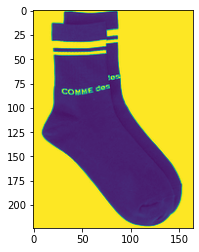

In [198]:
plt.imshow(d2[index]['img'][0])

In [189]:
img = Image.open('/media/yu-hao/WindowsData/FashionNewDataset/Accessories/129_Socks/socks6.JPG').convert('RGB')
width, height  = img.size
new_width  = width//2
new_height = height//2

img = img.resize((new_width, new_height), Image.ANTIALIAS)

#elif path.exists(self.img_list[idx].replace('.jpg', ''))

#print('Original Image size is ', width, height)
# Very Important
# For getting the cropped and resized region of interest image
img.thumbnail((224, 224), Image.ANTIALIAS)

img.show()
print(img.size)

(164, 224)


(3, 224, 164)


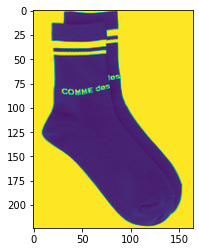

In [200]:
p1 = t1['img'].data.numpy()
print(p1.shape)
plt.imshow(p1[1])

In [38]:
# [STAR] MMFASHION Testing on a single image

attr_list = []
attr_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_attr_cloth.txt").read().split('\n')
for t in attr_list_file[2:-1]:
    attr_list.append(t.split()[0])
attr_list = np.array(attr_list)

cate_list = []
cate_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_category_cloth.txt").read().split('\n')
for t in cate_list_file[2:-1]:
    cate_list.append(t.split()[0])
cate_list = np.array(cate_list)

model.load_state_dict(torch.load('fashion_cate_attr_resnet50_single_linear.pth'))
model.eval()

index = random.randint(0, len(d2))
t1    = d2[index]

new_images  = torch.Tensor(np.expand_dims(t1['img'], 0)).to(device)
attr_target = t1['attr'].to(device)
cate_target = t1['cate'].to(device)
        
out1, out2  = model(new_images)
        
out1 = torch.sigmoid(out1)
out2 = torch.softmax(out2, axis=1)

out1 = out1.data.cpu().numpy().flatten()
out2 = out2.data.cpu().numpy().flatten()

out1[out1 < 0.5] = 0
out1 = np.array(out1.flatten())

attr_index         = np.array(np.nonzero(out1))
attr_ground_index  = np.array(np.nonzero(t1['attr']).flatten())

cate_index         = np.argmax(out2)
cate_ground_index  = t1['cate'].data.cpu().numpy()#[0][0]

print(cate_index, cate_ground_index)
print("Predicted:    ", cate_list[cate_index], attr_list[attr_index])
print("Ground Truth: ", cate_list[cate_ground_index], attr_list[attr_ground_index])
        

/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/img/Embroidered_Woven_Dress/img_00000015.jpg
Original Image size is  200 300
40 [40]
Predicted:     Dress [['solid' 'long_sleeve' 'mini_length' 'crew_neckline' 'cotton' 'loose']]
Ground Truth:  ['Dress'] ['solid' 'long_sleeve' 'mini_length' 'no_neckline' 'cotton' 'loose']


In [95]:
# [STAR] MMFASHION VALIDATION LOOP

from PIL import Image, ImageDraw, ImageFont

attr_list = []
attr_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_attr_cloth.txt").read().split('\n')
for t in attr_list_file[2:-1]:
    attr_list.append(t.split()[0])
attr_list = np.array(attr_list)

cate_list = []
cate_list_file = open("/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/list_category_cloth.txt").read().split('\n')
for t in cate_list_file[2:-1]:
    cate_list.append(t.split()[0])
cate_list = np.array(cate_list)

model.load_state_dict(torch.load('fashion_cate_attr_resnet50_single_linear.pth'))

loss_hist1  = Averager()
loss_hist2  = Averager()
loss_hist3  = Averager()


ce_loss  = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss()

batch_size = 1
counter    = 0
prev_min   = 1000

val_data_loader   = build_dataloader(d3, 1, False)

model.eval()

cat_array_result  = []
attr_array_result = []

img_fraction = 0.50
fontsize     = 17
txt          = "Hello World"

font = ImageFont.truetype("arial.ttf", fontsize)
        
with torch.no_grad():
    for t1 in val_data_loader:
        new_images  = torch.Tensor(t1['img']).to(device)
        #print(new_images.shape)
        
        #attr_target = t1['attr'].to(device)
        #cate_target = t1['cate'].to(device)
        
        #print(t1['attr'])
        #print(t1['cate'])
        
        #temp_img = np.array(t1['img'])[0]
        #print(t1['imgpath'])
        temp_img = Image.open(t1['imgpath'][0]).convert('RGB')
        #np.moveaxis(temp_img, 0, 2)
        #print('Image shape is ', temp_img.shape)
        
        img_save = temp_img#Image.fromarray(temp_img, 'RGB')
        
        out1, out2  = model(new_images)
        
        out1 = torch.sigmoid(out1)
        out2 = torch.softmax(out2, axis=1)
        
        out1 = out1.data.cpu().numpy().flatten()
        out2 = out2.data.cpu().numpy().flatten()
        
        out1[out1 < 0.5] = 0
        out1 = np.array(out1.flatten())
        
        attr_index         = np.array(np.nonzero(out1)[0])
        #attr_ground_index  = np.array(np.nonzero(t1['attr'][0]).flatten())
        
        cate_index         = np.argmax(out2)
        #cate_ground_index  = t1['cate'].data.cpu().numpy()[0][0]
        
        #print(cate_index, cate_ground_index)
        print(counter, "Predicted:    ", cate_list[cate_index], attr_list[attr_index])
        #print("Ground Truth: ", cate_list[cate_ground_index], attr_list[attr_ground_index])
        print('---------------------')
        
        txt = cate_list[cate_index]
        txt = txt+'\n'+ "\n".join( attr_list[attr_index])
        
        cat_array_result.append(cate_list[cate_index])
        attr_array_result.append(attr_list[attr_index])
        
        while font.getsize(txt)[0] < img_fraction*img_save.size[0]:
            # iterate until the text size is just larger than the criteria
            fontsize += 1
            font = ImageFont.truetype("arial.ttf", fontsize)
        
        #nt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
        d  = ImageDraw.Draw(img_save)
        d.text((10,10), txt,  fill=(0, 0, 0), font=font)
        img_save.save('/home/yu-hao/SEMISUNET/SHARE_RESULTS/'+str(counter)+'.png')
        
        counter = counter+1
        
        #break

0 Predicted:     Jumpsuit ['striped' 'pleated' 'sleeveless' 'maxi_length' 'no_dress' 'v_neckline'
 'no_neckline' 'cotton' 'conventional']
---------------------
1 Predicted:     Jumpsuit ['striped' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
2 Predicted:     Blouse ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'conventional']
---------------------
3 Predicted:     Jumpsuit ['striped' 'pleated' 'sleeveless' 'maxi_length' 'cotton' 'conventional']
---------------------
4 Predicted:     Jeans ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'denim' 'tight']
---------------------
5 Predicted:     Blouse ['solid' 'long_sleeve' 'no_dress' 'crew_neckline' 'cotton' 'conventional']
---------------------
6 Predicted:     Tee ['solid' 'long_sleeve' 'no_dress' 'crew_neckline' 'cotton' 'conventional']
---------------------
7 Predicted:     Jeans ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'denim' 'conventional']
---------------------
8 Predicted:     Cutoffs

71 Predicted:     Dress ['sleeveless' 'maxi_length' 'no_neckline' 'chiffon' 'conventional']
---------------------
72 Predicted:     Tank ['sleeveless' 'no_dress' 'crew_neckline' 'no_neckline' 'conventional']
---------------------
73 Predicted:     Shorts ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
74 Predicted:     Sweater ['solid' 'sleeveless' 'no_dress' 'crew_neckline' 'no_neckline' 'knit'
 'conventional']
---------------------
75 Predicted:     Dress ['sleeveless' 'no_dress' 'cotton' 'conventional']
---------------------
76 Predicted:     Dress ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
77 Predicted:     Tee ['solid' 'no_dress' 'cotton' 'conventional']
---------------------
78 Predicted:     Dress ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
79 Predicted:     Leggings ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'leather' 'tight']
--

142 Predicted:     Tee ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
143 Predicted:     Tee ['solid' 'short_sleeve' 'no_dress' 'crew_neckline' 'cotton' 'conventional']
---------------------
144 Predicted:     Joggers ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'denim' 'conventional']
---------------------
145 Predicted:     Shorts ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
146 Predicted:     Shorts ['floral' 'long_sleeve' 'no_dress' 'cotton' 'conventional']
---------------------
147 Predicted:     Blouse ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'cotton' 'conventional']
---------------------
148 Predicted:     Joggers ['solid' 'sleeveless' 'no_dress' 'no_neckline' 'denim' 'conventional']
---------------------
149 Predicted:     Sweater ['solid' 'long_sleeve' 'no_dress' 'crew_neckline' 'knit' 'conventional']
---------------------
150 Predicted:     Shorts ['solid' 'sleeveless' 'no_

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [87]:
# portion of image width you want text width to be

img_fraction = 0.50
fontsize     = 11
txt          = "Hello World"

font = ImageFont.truetype("arial.ttf", fontsize)
while font.getsize(txt)[0] < img_fraction*img_save.size[0]:
    # iterate until the text size is just larger than the criteria
    fontsize += 1
    font = ImageFont.truetype("arial.ttf", fontsize)

In [35]:
# [STAR] Code to Create the New dataset text file


a  = glob.glob('/media/yu-hao/WindowsData/FashionNewDataset/**/*.csv', recursive=True)


h = {}
count = 0
for t in a:
    #print(t)
    f = open(t).read().split('\n')[1:]
    
    for l in f:
        temp = l.split(',')[2:]
        temp = [x for x in temp if x]
        
        for l in temp:
            if l in h:
                h[l] = h[l]+1
            else:
                h[l] = 1
#print(h)

hnew = {}
for k in h:
    if h[k] >= 10:
        hnew[k] = h[k]

#print(hnew)


count         = 0
imagepathlist = []
imagecatlist  = []
imageattrlist = []
newdataset    = []

for t in a:
    f               = open(t).read().split('\n')[1:]
    imagefolderpath = "/".join(t.split('/')[:-1])
    
    for l in f:
        temp = l.split(',')
        temp = [x for x in temp if x]
        
        for k in temp:
            if k in hnew:
                if '.jpg' not in temp[0]:
                    imagename =  temp[0]+'.jpg'
                else:
                    imagename =  temp[0]
                
                imagepath = imagefolderpath+"/"+imagename
                
                category   = temp[1]
                attributes = temp[2:]
                
                imagepathlist.append(imagepath)
                imagecatlist.append(category)
                imageattrlist.append(attributes)
                
                #print(imagepath)
                #print(category, attributes)
                
                newdataset.append(imagepath+','+category+","+",".join(attributes))

newdataset = "\n".join(newdataset)
tp1 = open('newdataset.txt', 'w')
tp1.write(newdataset)
tp1.close()

In [213]:
# [STAR] For creating the Train, Validation and Test splits from the New Dataset

#Uncomment to Run

# images = np.array(open('newdataset.txt', 'r').read().split('\n')[:-1])
# print(len(images))

# shuffleindex = np.array(range(len(images)))
# random.shuffle(shuffleindex)
# print(shuffleindex)

# trainidx = np.array(shuffleindex[:6000])
# validx   = np.array(shuffleindex[6000:7000])
# testidx  = np.array(shuffleindex[7000:])

# train_images = images[trainidx]
# val_images   = images[validx]
# test_images  = images[testidx]

# print(train_images[0])


# f = open('newdataset_train.txt', 'w')
# f.write('\n'.join(train_images))
# f.close()

# f = open('newdataset_val.txt', 'w')
# f.write('\n'.join(val_images))
# f.close()

# f = open('newdataset_test.txt', 'w')
# f.write('\n'.join(test_images))
# f.close()


8373
[6309 1557 7212 ... 6936 4053 6960]
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/70_Robe/robe10.jpg,outerwear,coat,robe,longsleeves,nobutton,green


In [142]:
# [STAR] Code to read the entries in New dataset and print image shape etc.

images = open('newdataset.txt', 'r').read().split('\n')[:-1]
print(len(images))

shuffleindex = np.array(range(len(images)))
random.shuffle(shuffleindex)
print(shuffleindex)

trainidx = shuffleindex[:6000]
validx   = shuffleindex[6000:7000]
testidx  = shuffleindex[7000:]

#from PIL import Image

all_shapesx = []
all_shapesy = []

for index, t in enumerate(images):
    temp = t.split(',')
    p    = temp[0].replace('.jpg', '.JPG')
    c    = temp[1]
    a    = temp[2:]
    
    
    image = cv2.imread(p, cv2.IMREAD_COLOR)
    if image is None:
        p     = p.replace('.JPG', '.png')
        image = cv2.imread(p, cv2.IMREAD_COLOR)

        if image is not None:
            #pass
            print(p, image.shape, index)
            im1 = Image.open(p)
            im1 = im1.convert('RGB')
            im1.save(p.replace('.png', '.JPG'))
        else:
            print('Big error ', p)

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    #image /= 255.0
    
    #print(image.shape)

8428
[7346  615 6863 ... 7967 1764 3294]
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora21.png (516, 711, 3) 951
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora22.png (507, 694, 3) 953
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora23.png (435, 545, 3) 954
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora24.png (494, 542, 3) 955
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora25.png (381, 537, 3) 957
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora26.png (453, 676, 3) 959
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora27.png (384, 546, 3) 961
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora28.png (337, 405, 3) 962
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora29.png (381, 425, 3) 964
/media/yu-hao/WindowsData/FashionNewDataset/Accessories/133_Fedora/fedora30.p

/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/Slength/9_Midi/midi5.png (432, 358, 3) 3807
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/Slength/9_Midi/midi6.png (426, 296, 3) 3810
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/Slength/9_Midi/midi13.png (593, 417, 3) 3837
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/S_waistline/11_High/high1.png (650, 668, 3) 3865
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/S_waistline/11_High/high2.png (655, 586, 3) 3869
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/S_waistline/11_High/high3.png (377, 294, 3) 3873
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/S_waistline/11_High/high4.png (707, 602, 3) 3877
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/S_waistline/11_High/high5.png (677, 477, 3) 3880
/media/yu-hao/WindowsData/FashionNewDataset/Bottoms/Skirts/S_waistline/11_High/high6.png (543, 384, 3) 3883
/media/yu-hao/WindowsData/FashionNewDatase

/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted14.png (632, 586, 3) 6284
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted15.png (640, 606, 3) 6288
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted16.png (650, 608, 3) 6293
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted17.png (724, 417, 3) 6297
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted18.png (671, 656, 3) 6302
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted19.png (736, 492, 3) 6307
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/69_Quilted/quilted20.png (601, 531, 3) 6312
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/72_Teddy/teddy1.png (468, 474, 3) 6521
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/72_Teddy/teddy2.png (518, 383, 3) 6526
/media/yu-hao/WindowsData/FashionNewDataset/Outerwear/Coat/72_Teddy/teddy3.png (665

([<matplotlib.axis.XTick at 0x7f6272222c10>,
 [Text(0, 0, 'babypink'),
  Text(0, 0, 'cornflowerblue'),
  Text(0, 0, 'lavenderpurple'),
  Text(0, 0, 'opyumred'),
  Text(0, 0, 'bluered'),
  Text(0, 0, 'silverblack'),
  Text(0, 0, 'blackgold'),
  Text(0, 0, 'goldblack'),
  Text(0, 0, 'goldpurple'),
  Text(0, 0, 'pinkrhodium'),
  Text(0, 0, 'silvergold'),
  Text(0, 0, 'ballerinapink'),
  Text(0, 0, 'brightorange'),
  Text(0, 0, 'deepbeige'),
  Text(0, 0, 'lightbeige'),
  Text(0, 0, 'mottygrey'),
  Text(0, 0, 'softbeige'),
  Text(0, 0, 'yellowgrey'),
  Text(0, 0, 'muddygreen'),
  Text(0, 0, 'rustbrown'),
  Text(0, 0, 'crystal'),
  Text(0, 0, 'goldenwhite'),
  Text(0, 0, 'pearlwhite'),
  Text(0, 0, 'silverred'),
  Text(0, 0, 'goldengreen'),
  Text(0, 0, 'lightmustard'),
  Text(0, 0, 'naturalbrown'),
  Text(0, 0, 'copperbrown'),
  Text(0, 0, 'ivorywhite'),
  Text(0, 0, 'turquoiseblue'),
  Text(0, 0, 'blushpink'),
  Text(0, 0, 'fluorescentpink'),
  Text(0, 0, 'jadegreen'),
  Text(0, 0, 'rustre

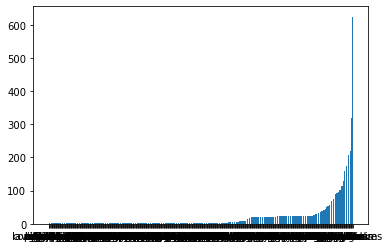

In [20]:
# For plotting the histogram of the dataset attributes

import matplotlib.pyplot as plt 

h = {k: v for k, v in sorted(h.items(), key=lambda item: item[1])}

#h = sorted(h, key=h.get)
#print(sortlist)

ticks = range(len(h))
plt.bar(ticks, h.values(), align='center')
plt.xticks(ticks, h.keys())

In [63]:
cat_array_result = '\n'.join([str(x) for x in cat_array_result])
attr_array_result = '\n'.join([str(x) for x in attr_array_result])

f = open("cat_array_result.txt", "w")
f.write(cat_array_result)
f.close()

f = open("attr_array_result.txt", "w")
f.write(attr_array_result)
f.close()


In [ ]:
img_list_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"

train_cate_path = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_cate.txt"
train_attr_path = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_attr.txt"


img_list = open(img_list_path).read()
img_list = img_list.split("\n")[:-1]

print(len(img_list))
basepath = ""

for i in tqdm(range(len(img_list))):
    #print(img_list[i])
    img_path = basepath+"/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/"+img_list[i]
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    #print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    print(image.shape)

In [23]:
import random

img_list_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"

img_list = open(img_list_path).read()
img_list = img_list.split("\n")[:-1]

#print(img_list)
index = random.randint(0, 10000)
print(index, img_list[index])

6197 img/Wifey_Graphic_Muscle_Tee/img_00000018.jpg
